In [2]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os

from scipy import linalg as la
from imageio import imread
from matplotlib import pyplot as plt
from scipy import sparse
from scipy.sparse import linalg as las

Reading image...


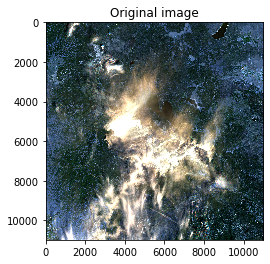

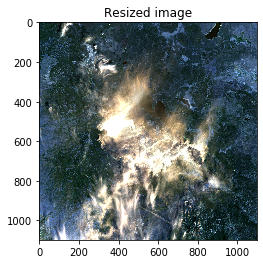

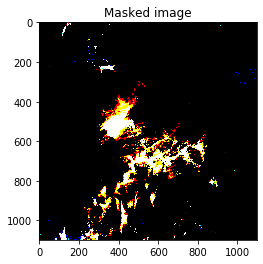

In [2]:
def mask_values(path):
    print("Reading image...")
    img = cv2.imread(path)
    #Plot original image for reference
    fig,ax = plt.subplots()
    ax.set_title("Original image")
    ax.imshow(img)
    
    #Resize image to be a little more manageable to work with
    scale_percent = 10 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    
    #Plot resized image
    fig,ax = plt.subplots()
    ax.set_title("Resized image")
    ax.imshow(resized) #Notice time difference between original image, MUCH faster
    
    #Plot masked image
    mask = resized > 225 #This value gave the best result after playing around with different values
    fig,ax = plt.subplots()
    ax.set_title("Masked image")
    ax.imshow(mask * resized) #Plot masked image
    
path = 'D:\SatelliteImages\DixieFire\S2A_MSIL2A_20210728T184921_N0301_R113_T10TFK_20210728T230926\S2A_MSIL2A_20210728T184921_N0301_R113_T10TFK_20210728T230926.SAFE\GRANULE\L2A_T10TFK_A031856_20210728T185732\IMG_DATA\R10m\T10TFK_20210728T184921_TCI_10m.jp2'
mask_values(path)

Reading channels...


C:\Users\97jak\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


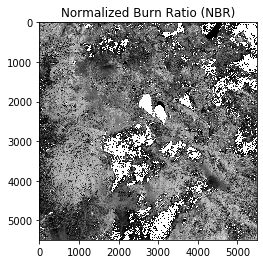

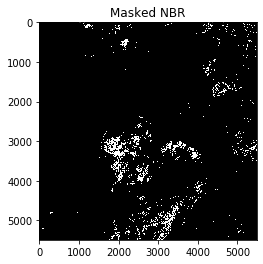

In [3]:
def mask_nbr(b08_path, b12_path):
    #Read in B08 and B12 channels
    print("Reading channels...")
    b08 = cv2.imread(b08_path)
    b12 = cv2.imread(b12_path)
    
    #Calculate NBR
    #NOTE - doing this in Python returns a pretty crappy product
    #It's much better to do this in QGIS and import 
    nbr = (b08 - b12) / (b08 + b12)
    
    fig,ax = plt.subplots()
    ax.set_title("Normalized Burn Ratio (NBR)")
    ax.imshow(nbr) #Plot NBR
    
    new_nbr = np.nan_to_num(nbr) #Make sure we don't have Nan values in NBR
    
    mask = new_nbr > 10 #Mask NBR
    
    fig,ax = plt.subplots()
    ax.set_title("Masked NBR")
    ax.imshow(new_nbr * mask) #Plot NBR
    
    
b08_path = 'D:\SatelliteImages\DixieFire\S2A_MSIL2A_20210728T184921_N0301_R113_T10TFK_20210728T230926\S2A_MSIL2A_20210728T184921_N0301_R113_T10TFK_20210728T230926.SAFE\GRANULE\L2A_T10TFK_A031856_20210728T185732\IMG_DATA\R20m\T10TFK_20210728T184921_B8A_20m.jp2'
b12_path = 'D:\SatelliteImages\DixieFire\S2A_MSIL2A_20210728T184921_N0301_R113_T10TFK_20210728T230926\S2A_MSIL2A_20210728T184921_N0301_R113_T10TFK_20210728T230926.SAFE\GRANULE\L2A_T10TFK_A031856_20210728T185732\IMG_DATA\R20m\T10TFK_20210728T184921_B12_20m.jp2'

mask_nbr(b08_path, b12_path)

Well there's some potential here, but it's very clear there are a lottt of problems. 

1) Our mask value was pretty arbitrary and based on empirical observation a.k.a. I tested a bunch of different mask values and arbitrarily picked one that looked semi-decent. We aren't guaranteed for this mask value to be universally decent. 
<br>2) There's an insane amount of noise in our masks. There are random dots of 'fire' everywhere. If we increase the mask value, we get a lot less noise but we also lose a lot of the actual fire. It's seemingly impossible to get rid of the outside noise while maintaining model integrity using masking alone.
<br>3) We haven't really 'solved' the problem. We've really only identified bright pixels, while we want to create a fire boundary. Maybe we'll be able to use these masked images in future image segmentation efforts but for now they're seemingly useless.
<br>
<br>
Let's try some image segmentation and see what we get...

In [31]:
def scale_image(img,pct):
    scale_percent = pct # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

In [66]:
path = 'D:\SatelliteImages\DixieFire\S2A_MSIL2A_20210728T184921_N0301_R113_T10TFK_20210728T230926\S2A_MSIL2A_20210728T184921_N0301_R113_T10TFK_20210728T230926.SAFE\GRANULE\L2A_T10TFK_A031856_20210728T185732\IMG_DATA\R10m\T10TFK_20210728T184921_TCI_10m.jp2'
img = cv2.imread(path)

In [46]:
def K_means_clustering(img, K, perc=10):

    img = scale_image(img,perc)

    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    twoDimage = img.reshape((-1,3))
    twoDimage = np.float32(twoDimage)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    attempts=10

    ret,label,center=cv2.kmeans(twoDimage,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((img.shape))
    
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title("Original Image")
    ax1.axis('off')
    ax1.imshow(img) #Plot NBR

    ax2.set_title("Segmented Image with K = {}".format(K))
    ax2.axis('off')
    ax2.imshow(result_image) #Plot NBR

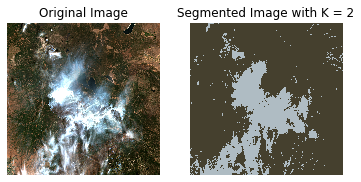

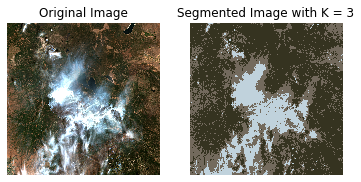

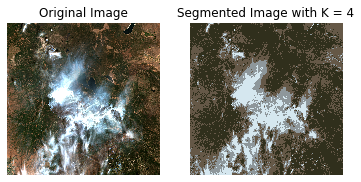

In [45]:
for i in range(2,5):
    K_means_clustering(img,i)

Well this seems pretty decent, but there's really no reason to do anything above K = 2 because we only want to segment the image into 'burned' and 'not burned' and K>2 makes more segments that we probably don't need. Looking at K=2 though, it seems like we've segmented the image into 'smoke' and 'not smoke' rather than 'burned' and 'not burned'. Let's try running K-means segmentation on an NBR image (an actual one calculated from QGIS) instead of an original image.

In [62]:
def contour_detection(img,perc=10):
    img = scale_image(img,perc)

    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    _,thresh = cv2.threshold(gray, np.mean(gray), 255, cv2.THRESH_BINARY_INV)
    edges = cv2.dilate(cv2.Canny(thresh,0,255),None)


    cnt = sorted(cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-1]
    mask = np.zeros((256,256), np.uint8)
    masked = cv2.drawContours(mask, [cnt],-1, 255, -1)

    #dst = cv2.bitwise_and(img, img, mask=mask)
    #segmented = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    
    f, (ax1, ax2) = plt.subplots(1, 2)
    
    ax1.set_title("Original Image")
    ax1.axis('off')
    ax1.imshow(img) #Plot NBR

    ax2.set_title("Contour Segmentation")
    ax2.axis('off')
    ax2.imshow(masked) #Plot NBR


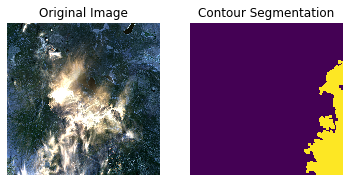

In [63]:
contour_detection(img)

This method seemingly sucks but to be fair, I don't know what a lot of this stuff is actually doing so I can't really try to improve it at this time. That last part that is commented out was throwing me an error but I'm pretty sure that all that is doing is applying the mask to the original image and then turning it back to color.

In [73]:
def get_neighbors(index, radius, height, width):
    """Calculate the flattened indices of the pixels that are within the given
    distance of a central pixel, and their distances from the central pixel.

    Parameters:
        index (int): The index of a central pixel in a flattened image array
            with original shape (radius, height).
        radius (float): Radius of the neighborhood around the central pixel.
        height (int): The height of the original image in pixels.
        width (int): The width of the original image in pixels.

    Returns:
        (1-D ndarray): the indices of the pixels that are within the specified
            radius of the central pixel, with respect to the flattened image.
        (1-D ndarray): the euclidean distances from the neighborhood pixels to
            the central pixel.
    """
    # Calculate the original 2-D coordinates of the central pixel.
    row, col = index // width, index % width

    # Get a grid of possible candidates that are close to the central pixel.
    r = int(radius)
    x = np.arange(max(col - r, 0), min(col + r + 1, width))
    y = np.arange(max(row - r, 0), min(row + r + 1, height))
    X, Y = np.meshgrid(x, y)

    # Determine which candidates are within the given radius of the pixel.
    R = np.sqrt(((X - col)**2 + (Y - row)**2))
    mask = R < radius
    return (X[mask] + Y[mask]*width).astype(np.int), R[mask]

In [74]:
class ImageSegmenter:
    """Class for storing and segmenting images."""

    # Problem 3
    def __init__(self, image):
        """Read the image file. Store its brightness values as a flat array."""
        self.grayscale = False
        
        #Scale the image
        self.scaled = image / 255
        
        #If color, average each color to convert to grayscale
        shape = np.shape(self.scaled)
        if len(shape) == 3:
            self.brightness = self.scaled.mean(axis=2)
            self.rows,self.columns,self.height = np.shape(self.scaled)
        else:
            self.brightness = self.scaled
            self.grayscale = True
            self.rows,self.columns = np.shape(self.scaled)
            self.height = 0
        
        M,N = self.brightness.shape
        self.flat_brightness = np.ravel(self.brightness)
        
        
        

    # Problem 3
    def show_original(self):
        """Display the original image."""
        #Check for grayscale
        if self.grayscale == True:
            plt.imshow(self.scaled, cmap="gray")
            plt.axis("off")
            
        #Else color image
        else:
            plt.imshow(self.scaled)
            plt.axis("off")

    # Problem 4
    def adjacency(self, r=5., sigma_B2=.02, sigma_X2=3.):
        """Compute the Adjacency and Degree matrices for the image graph."""
        #Get number of pixels
        size = len(self.flat_brightness)

        #Create an empty sparse matrix
        A = sparse.lil_matrix((size,size))
        
        #Loop through each pixel
        for i in range(size):
            
            #For each pixel, get pixels within radius r and distances to each pixel
            indices, distances = get_neighbors(i,r,self.rows,self.columns)
            
            #For each pixel in radius r
            for j in range(len(indices)):
                
                #Calculate weight of each pixel
                weight = np.exp(-(abs(self.flat_brightness[i] - self.flat_brightness[indices[j]])/sigma_B2)-distances[j]/sigma_X2)
                
                #Update sparse matrix
                A[i, indices[j]] = weight
        
        #Change A to a csc matrix
        A = A.tocsc()
        
        return A, np.array(np.sum(A,axis=1)).reshape((1,size))[0]

    # Problem 5
    def cut(self, A, D):
        """Compute the boolean mask that segments the image."""
        
        #Get laplacian of A
        L = sparse.csgraph.laplacian(A)
        
        #Calculate D^(-.5)LD^(-.5)
        D = 1/np.sqrt(D)
        D_2 = sparse.diags(D)
        X = D_2@L@D_2
        
        #Get eigenvalues and vectors of D^(-.5)LD^(-.5)
        vals,vectors = las.eigsh(X,which='SM',k=2)
        
        #Get eigenvector associated with the algebraic connectivity
        eig_vector = vectors[:,1].reshape((self.rows,self.columns))
        
        #Create mask
        mask = eig_vector > 0
        
        return mask
        

    # Problem 6
    def segment(self, r=5., sigma_B=.02, sigma_X=3.):
        """Display the original image and its segments."""
        #Get mask for A
        A,D = self.adjacency(r,sigma_B,sigma_X)
        mask = self.cut(A,D)
        
        #Plot original image
        plt.subplot(131)
        self.show_original()
        
        #Plot images if they're grayscale
        if self.grayscale == True:
            P = self.scaled * mask
            N = self.scaled * ~mask
            
            plt.subplot(132)
            plt.imshow(P, cmap="gray")
            plt.axis("off")
            
            plt.subplot(133)
            plt.imshow(N, cmap="gray")
            plt.axis("off")
            
        #Plot images if they're color
        else:
            mask = np.dstack((mask,mask,mask))
            
            P = self.scaled * mask
            N = self.scaled * ~mask
            
            plt.subplot(132)
            plt.imshow(P)
            plt.axis("off")
            
            plt.subplot(133)
            plt.imshow(N)
            plt.axis("off")

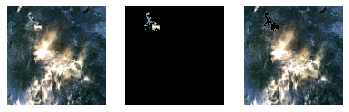

In [76]:
resized_img = scale_image(img,1)

ImageSegmenter(resized_img).segment()

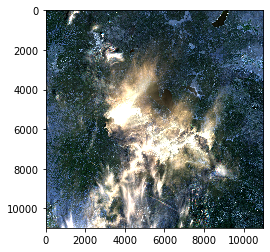

In [77]:
plt.imshow(img)

I have no idea what this method even ended up segmenting. I don't think it's worth exploring further. The last method I'll try is Non-negative Matrix Factorization, or NMF for short.

In [28]:
import os
from sklearn.decomposition import NMF

In [46]:
path = 'D:\SatelliteImages\DixieFire\S2A_MSIL2A_20210728T184921_N0301_R113_T10TFK_20210728T230926\S2A_MSIL2A_20210728T184921_N0301_R113_T10TFK_20210728T230926.SAFE\GRANULE\L2A_T10TFK_A031856_20210728T185732\IMG_DATA\R20m'

def construct_matrix(path):
    os.chdir(path)
    
    bands = os.listdir()[1:10]
    band_arrays = [cv2.imread(os.path.join(os.getcwd(),b)) for b in bands]

    resized_bands = [scale_image(b,10) for b in band_arrays]
    reshaped_bands = [b.reshape(-1,1) for b in resized_bands]
    m = np.column_stack(reshaped_bands)
    
    return m, resized_bands[0].shape

In [47]:
def matrix_factorization(m, n):
    
    model = NMF(n_components=n)
    
    W = model.fit_transform(m)
    
    return W

In [51]:
def plot_NMF(W,dims):
    
    for i in range(W.shape[1]):
        plt.figure()
        plt.imshow(W[:,i].reshape(dims),cmap='gray')



In [48]:
m, dims = construct_matrix(path)

Solving NMF for 2 components...
Plotting columns of W matrix...


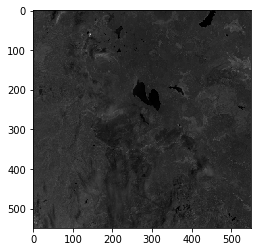

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


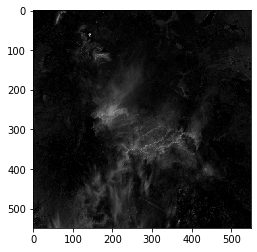

Solving NMF for 3 components...
Plotting columns of W matrix...


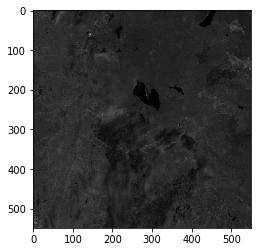

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


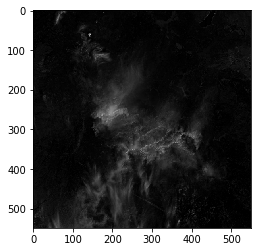

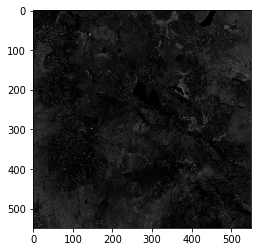

Solving NMF for 4 components...
Plotting columns of W matrix...


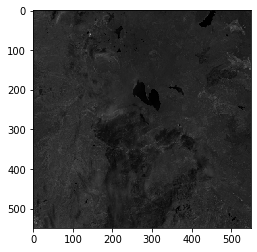

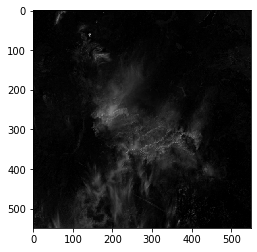

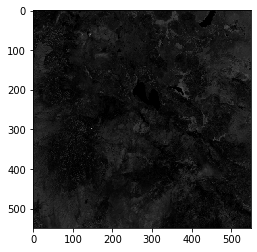

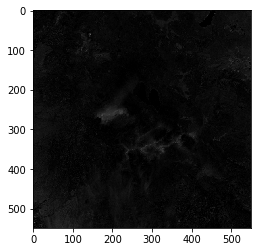

Solving NMF for 5 components...
Plotting columns of W matrix...


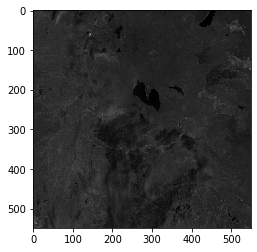

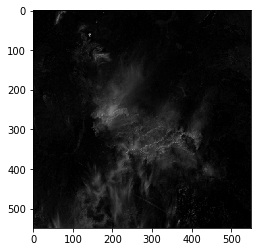

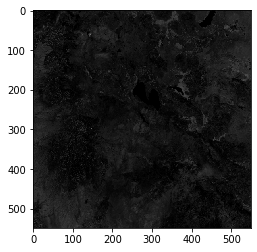

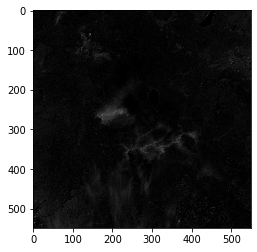

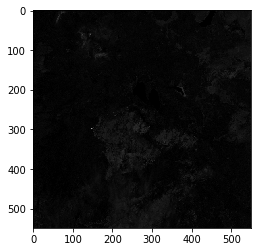

In [55]:
for i in range(2,6):
    
    print("Solving NMF for {} components...".format(i))
    W = matrix_factorization(m,i)
    
    print("Plotting columns of W matrix...")
    for j in range(W.shape[1]):
        plt.figure()
        plt.imshow(W[:,j].reshape(dims))
        plt.show()

NMF actually did pretty good and I think shows a lot of potential. The biggest issue is the amount of user invovlement I think. It would take a user to decide how many factors to use as well as decide which column is the one you want to use. It is very conceivable to think that both of these factors could change from image to image, so there may not be a universal answer, making its usage potentially costly. But, like I said, I think this method merits more exploration in the future. 